# Generative AI Triage Demo
**Task:** Simulate automated intake for public requests (categorize → summarize → route).  
**Models:** `facebook/bart-large-mnli` (zero-shot classification), `sshleifer/distilbart-cnn-12-6` (summarization)  
**Runtime:** GPU (T4 preferred)

---


# Runtime & libraries

In [ ]:
# If needed: Runtime > Change runtime type > GPU
!nvidia-smi -L || true
!pip -q install --upgrade torch transformers accelerate tqdm

import os, json, requests, math
import pandas as pd
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from transformers import pipeline

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
    os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
    try: torch.set_float32_matmul_precision("high")
    except: pass

DEVICE = 0 if torch.cuda.is_available() else -1
DTYPE  = torch.float16 if torch.cuda.is_available() else None


GPU 0: Tesla T4 (UUID: GPU-8314db5b-0138-9282-e5ed-b83ad90a5efa)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 628.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 562.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 151.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 77.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.3/322.3 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.3/39.3 MB 

# 2) Load a small public dataset (simulating requests)

In [ ]:
# 20-Newsgroups (public mirror) — treat 'content' as request text and 'target_names' as labels
URL = "https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json"
raw = json.loads(requests.get(URL).text)
df = pd.DataFrame(raw)[["content","target_names"]].rename(
    columns={"content":"request_text","target_names":"true_label"}
).dropna().reset_index(drop=True)

# SAMPLE SIZE for demo speed (change to None to use full set)
SAMPLE_SIZE = 50  # e.g., 50 for demo; set to None for full
if SAMPLE_SIZE:
    df = df.sample(SAMPLE_SIZE, random_state=42).reset_index(drop=True)

print(f"Loaded {len(df)} rows")
df.head(3)


Loaded 50 rows


,request_text,true_label
0,From: rrn@po.CWRU.Edu (Robert R. Novitskey)\nS...,comp.sys.mac.hardware
1,From: ardie@ux1.cso.uiuc.edu (Ardie Mack)\nSub...,comp.os.ms-windows.misc
2,From: tsa@cellar.org (The Silent Assassin)\nSu...,misc.forsale


# 3) Categories (candidate labels) + Department routing map

In [ ]:
# Categories for zero-shot classification (map to departments for routing)
CATEGORIES = [
    "rec.autos", "misc.forsale", "comp.graphics", "comp.sys.mac.hardware",
    "rec.sport.hockey", "sci.electronics", "sci.space",
    "talk.politics.misc", "soc.religion.christian", "talk.religion.misc"
]

ROUTE_MAP = {
    "rec.autos": "Transportation",
    "misc.forsale": "Commerce / Marketplace",
    "comp.graphics": "IT / Digital Services",
    "comp.sys.mac.hardware": "IT / Device Support",
    "rec.sport.hockey": "Parks & Recreation",
    "sci.electronics": "IT / Digital Services",
    "sci.space": "Innovation & Research",
    "talk.politics.misc": "City Clerk / Council",
    "soc.religion.christian": "Community & Cultural Affairs",
    "talk.religion.misc": "Community & Cultural Affairs",
}


# 4) Build GPU-backed pipelines

In [ ]:
clf = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli",
    device=DEVICE,
    torch_dtype=DTYPE,
    truncation=True
)

summarizer = pipeline(
    "summarization",
    model="sshleifer/distilbart-cnn-12-6",
    device=DEVICE,
    torch_dtype=DTYPE,
    truncation=True
)

print("Pipelines ready.")


Device set to use cuda:0
Device set to use cuda:0


Pipelines ready.


# 5) Batched helpers (fast + memory-safe)

In [ ]:
def batched_zero_shot(texts, candidate_labels, batch_size=8):
    preds, confs = [], []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        outs = clf(batch, candidate_labels=candidate_labels, multi_label=False, truncation=True)
        if isinstance(outs, dict): outs = [outs]
        for o in outs:
            preds.append(o["labels"][0])
            confs.append(float(o["scores"][0]))
    return preds, confs

def batched_summaries(texts, batch_size=6, max_len=40, min_len=8):
    sums = []
    for i in range(0, len(texts), batch_size):
        batch = [str(t)[:2000] for t in texts[i:i+batch_size]]
        out = summarizer(batch, max_length=max_len, min_length=min_len, do_sample=False)
        sums.extend([o["summary_text"].strip() for o in out])
    return sums


# 6) Run categorization + summarization + routing

In [ ]:
# Categorize
preds, confs = batched_zero_shot(df["request_text"].tolist(), CATEGORIES, batch_size=8)
df["predicted_category"] = preds
df["confidence"] = confs

# Summaries (optional; comment out to skip)
df["summary"] = batched_summaries(df["request_text"].tolist(), batch_size=6)

# Routing
df["department_owner"] = df["predicted_category"].map(ROUTE_MAP).fillna("General Intake")

df[["request_text","summary","predicted_category","confidence","department_owner"]].head()


,request_text,summary,predicted_category,confidence,department_owner
0,From: rrn@po.CWRU.Edu (Robert R. Novitskey)\nS...,"""Pursuing women is similar to banging one's he...",misc.forsale,0.369705,Commerce / Marketplace
1,From: ardie@ux1.cso.uiuc.edu (Ardie Mack)\nSub...,The defrag looks very much like Norton Speedis...,rec.autos,0.316242,Transportation
2,From: tsa@cellar.org (The Silent Assassin)\nSu...,From: tsa@cellar.org (The Silent Assassin) Abo...,misc.forsale,0.735437,Commerce / Marketplace
3,From: guy@idacom.hp.com (Guy M. Trotter)\nSubj...,"In Canada, any gun that enters a National Park...",misc.forsale,0.266381,Commerce / Marketplace
4,From: jwodzia@fadel.uucp (john wodziak)\nSubje...,The official Language of Golf is Profanity . J...,rec.sport.hockey,0.196424,Parks & Recreation


# 7) Quick evaluation + visualization + export

Accuracy on sample: 0.120


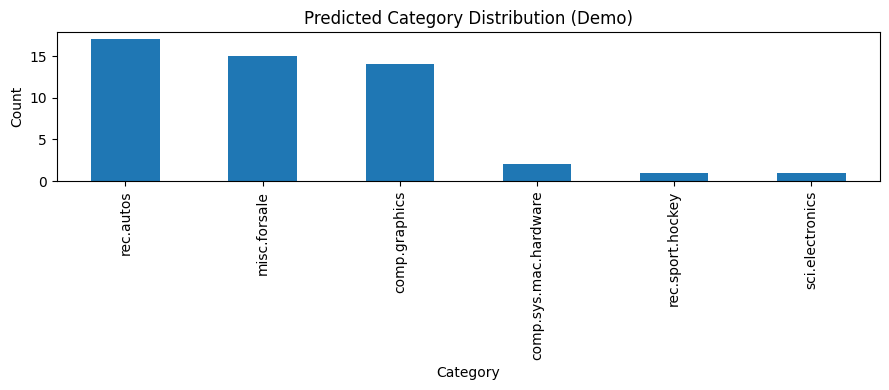

Saved: /content/demo_predictions_with_summaries_and_routing.csv

=== Prototype Evidence (sample) ===
- "Pursuing women is similar to banging one's head against a wall...with less opportunity for reward"... → **misc.forsale** (Commerce / Marketplace, conf 0.37)
- The defrag looks very much like Norton Speedisk, says Kiseok Lee . Geoffrey S. Elbo writes: "It is the fastest... → **rec.autos** (Transportation, conf 0.32)
- From: tsa@cellar.org (The Silent Assassin) About 10.25" Internal Low density disk drive . From: For Sale:  Mis... → **misc.forsale** (Commerce / Marketplace, conf 0.74)
- In Canada, any gun that enters a National Park must be sealed . The net result of this is that you can't use a... → **misc.forsale** (Commerce / Marketplace, conf 0.27)
- The official Language of Golf is Profanity . John Vanbiesbrouck's mask has a skyline of New York and on the si... → **rec.sport.hockey** (Parks & Recreation, conf 0.20)


In [ ]:
# Accuracy (only meaningful here because dataset has labels)
if "true_label" in df.columns:
    acc = (df["predicted_category"] == df["true_label"]).mean()
    print(f"Accuracy on sample: {acc:.3f}")

# Distribution chart
plt.figure(figsize=(9,4))
df["predicted_category"].value_counts().plot(kind="bar")
plt.title("Predicted Category Distribution (Demo)")
plt.xlabel("Category"); plt.ylabel("Count"); plt.tight_layout()
plt.show()

# Export CSV + memo snippet
OUT = "/content/demo_predictions_with_summaries_and_routing.csv"
df.to_csv(OUT, index=False)
print("Saved:", OUT)

print("\n=== Prototype Evidence (sample) ===")
for _, r in df.head(5).iterrows():
    preview = (r["summary"] or r["request_text"])[:110].replace("\n"," ")
    print(f"- {preview}... → **{r['predicted_category']}** ({r['department_owner']}, conf {r['confidence']:.2f})")
